# 1 Explore the Data

In [259]:
#Reset variables for repeated runs
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [260]:
#Import packages/libraries
import pandas as pd
import numpy as np
from numpy import linalg as LA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy import stats # ANOVA
import re
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing

### 1.1 Load the data

Note- I am DROPPING the "worst" columns since modelling based on outliers seems counter-intuitive. I'm also dropping "se" columns since we don't use the standard error anywhere in our problem. I acknowledge this is not alright in the real world since I don't have the domain knowledge necessary to evaluate whether this is a good decision or not; and will bear more caution when doing so in the future. I ran this by the professor who echoed doing so is premature, but I shouldn't worry too much if doing so for the purposes of this exercise.

In [391]:
#Read data
wdbc = pd.read_csv("D:\\OneDrive\\University of Washington Seattle\\Year 4 Quarter 2 (Winter)\\INFO 371\\Problem Set\\PS5\\wdbc.csv", sep=',')

#Dictionary with mapping we want
Cancer = {'M': 1,'B': 0} 

#Loop dataframe and write value where key matches
cancer = [Cancer[item] for item in wdbc.diagnosis]

#Drop diagnosis, id column since not required
wdbc = wdbc.drop(columns=['id', 'diagnosis'])

#Append cancer diagnosis column
wdbc['cancer'] = cancer

#Dropping "worst", "se" columns
wdbc_summ = wdbc[[c for c in wdbc.columns if  (c.lower()[len(c) - 3:len(c)] != '.se') & (c.lower()[len(c) - 6:len(c)] != '.worst')]]

### 1.2 Summary table with mean, range, missing values, and corr. b/w diagnosis and feature

In [392]:
#Calculate null values
wdbc_null = wdbc_summ.isnull().sum().transpose()

#Get summary table
wdbc_summ = wdbc_summ.describe().transpose()

#Append correlation values
wdbc_summ['corr'] = wdbc.corrwith(wdbc.cancer)

#Append null values column
wdbc_summ['missing values']= wdbc_null

#Drop columns for unneeded data
wdbc_summ = wdbc_summ.drop(columns=['25%', '50%', '75%'])

#Print table
wdbc_summ

,count,mean,std,min,max,corr,missing values
radius.mean,569.0,14.127292,3.524049,6.98100,28.11000,0.730029,0
texture.mean,569.0,19.289649,4.301036,9.71000,39.28000,0.415185,0
perimeter.mean,569.0,91.969033,24.298981,43.79000,188.50000,0.742636,0
area.mean,569.0,654.889104,351.914129,143.50000,2501.00000,0.708984,0
smoothness.mean,569.0,0.096360,0.014064,0.05263,0.16340,0.358560,0
compactness.mean,569.0,0.104341,0.052813,0.01938,0.34540,0.596534,0
concavity.mean,569.0,0.088799,0.079720,0.00000,0.42680,0.696360,0
concpoints.mean,569.0,0.048919,0.038803,0.00000,0.20120,0.776614,0
symmetry.mean,569.0,0.181162,0.027414,0.10600,0.30400,0.330499,0
fracdim.mean,569.0,0.062798,0.007060,0.04996,0.09744,-0.012838,0


### 1.3 Diagnosis vs. Feature graph

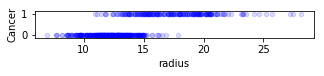

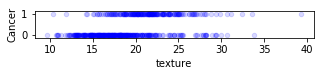

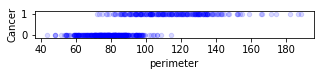

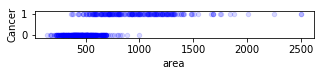

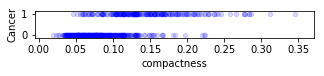

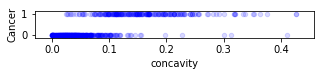

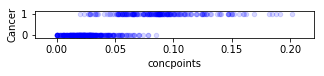

In [263]:
#Create sub-table for values with correlation greater than 0.5
wdbc_mean = wdbc[[c for c in wdbc.columns if  (c.lower()[len(c) - 3:len(c)] != '.se') & (c.lower()[len(c) - 6:len(c)] != '.worst')]].drop(columns=['symmetry.mean', 'fracdim.mean', 'smoothness.mean', 'cancer'])

#Make a graph for each strongly correlated column vs. cancer
for feature in list(wdbc_mean):    
    plt.figure(figsize=(5,0.5))
    plt.ylabel("Cancer")
    plt.xlabel(feature[0:len(feature) - 5])
    plt.scatter(wdbc[feature], wdbc['cancer'], facecolor='blue', alpha = 0.15, s = 20)
    plt.show()

# 2. Decision Boundary

Normalizing the data

In [264]:
#Normalizing the Data
scaler = preprocessing.StandardScaler()
names = wdbc.columns
wdbc = scaler.fit_transform(wdbc)
wdbc = pd.DataFrame(wdbc, columns=names)

wdbc['cancer'] = cancer

D:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Software\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Selecting top 2 features

In [421]:
#Selecting top 2 features
wdbc_feat = wdbc[['cancer', 'perimeter.mean', 'concpoints.mean']]
wdbc_feat.columns = ['cancer', 'perimeter', 'concpoints']

#Split intro training, test
X_train, X_test, y_train, y_test = train_test_split(wdbc_feat.drop(columns=['cancer']), wdbc_feat.cancer, train_size = 0.9, random_state = 1)
Train, Test = train_test_split(wdbc_feat, train_size = 0.9, random_state = 1)

D:\Software\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Commonly used functions

In [387]:
#Plots training data + predicted data + decision boundary; adapted from Overfitting lab
def gridshow(m, X, Y, pred, Xv=None, Yv=None, nGrid=100):
    ex1 = np.linspace(X[:,0].min(), X[:,0].max(), nGrid)
    ex2 = np.linspace(X[:,1].min(), X[:,1].max(), nGrid)
    xx1, xx2 = np.meshgrid(ex1, ex2)
    g = np.stack((xx1.ravel(), xx2.ravel()), axis=1)
    hatY = m.predict(g).reshape(nGrid,nGrid)
    plt.figure(figsize=(11,11))
    plt.imshow(hatY, extent=(X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()), interpolation='none', origin='lower', alpha=1)
    Yvpred = m.predict(Xv)
    
    #####################
    #Finds predicted values that are different from actual
    df = pd.DataFrame({'x1':Xv[:,0],'x2':Xv[:,1],'yTrue':Yv, 'yPred':pred})
    df = df[df.yTrue != df.yPred]
    X1 = (df).reset_index()['x1']
    X2 = (df).reset_index()['x2']
    Ydf = (df).reset_index()['yPred']
    Xdf = np.stack((X1, X2), axis=1)
    #####################
    
    #Plots training data
    plt.scatter(X[:,0], X[:,1], c=Y, s=60, edgecolors='k')
    
    #Plots testing data
    plt.scatter(Xv[:,0], Xv[:,1], c=Yv, s=60, edgecolors='r')

    #Plots misclassified predictions
    plt.scatter(Xdf[:,0], Xdf[:,1], c=Ydf, s=60, edgecolors='g')

    #Print title, axis, legend
    plt.ylabel('Perimeter (normalized)')
    plt.xlabel('Concpoints (normalized)')
    plt.title('Classification based on Perimeter vs. Concpoints data')

    plt.show()
    print("Legend (Circle Outlines):")
    print("   Black: Training")
    print("   Red: Testing")
    print("   Green: Misclassified data (true = color flipped)")
    print("   Purple: benign")
    print("   Yellow: malignant")

    
#Plots data + decision boundary
def dataShow(m, X, Y, opacity):
    ex1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    ex2 = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    xx1, xx2 = np.meshgrid(ex1, ex2)
    g = np.stack((xx1.ravel(), xx2.ravel()), axis=1)
    hatY = m.predict(g).reshape(100,100)
    plt.figure(figsize=(10,10))

    #Print title, axis, legend
    plt.ylabel('Perimeter (normalized)')
    plt.xlabel('Concpoints (normalized)')
    plt.title('Classification based on Perimeter vs. Concpoints data')

    plt.imshow(hatY, extent=(X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()), interpolation='none', origin='lower', alpha = opacity)
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.show()
    print("Legend (Circle Outlines):")
    print("   Purple: benign")
    print("   Yellow: malignant")

## 2.1 kNN Case
Note- Instructions asked for k=3.7. I've selected 4 since k needs to be an integer

In [292]:
#Develop, train kNN model 
kNN_model = KNeighborsClassifier(n_neighbors = 4)

#Next, fit the data by: kNNTool.fit(X, y) 
kNN_model.fit(X = X_train, y = y_train)

#Append column with predictions
knn_Pred = kNN_model.predict(X_test)

#Print Accuracy
print("accuracy:", np.mean(y_test == knn_Pred))

accuracy: 0.9122807017543859


### 2.1.1 Predict Diagnosis on grid

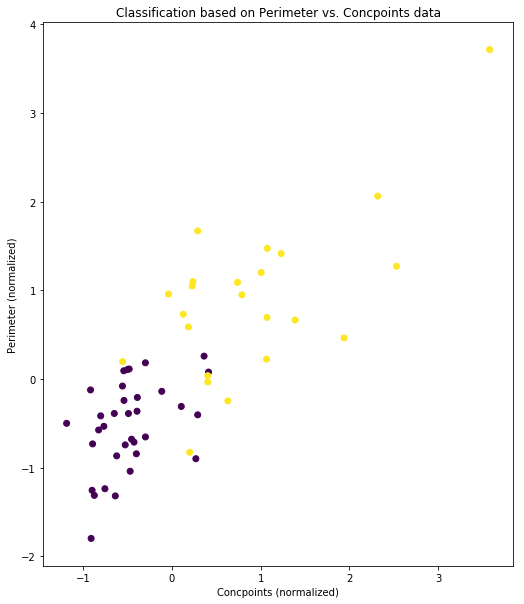

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


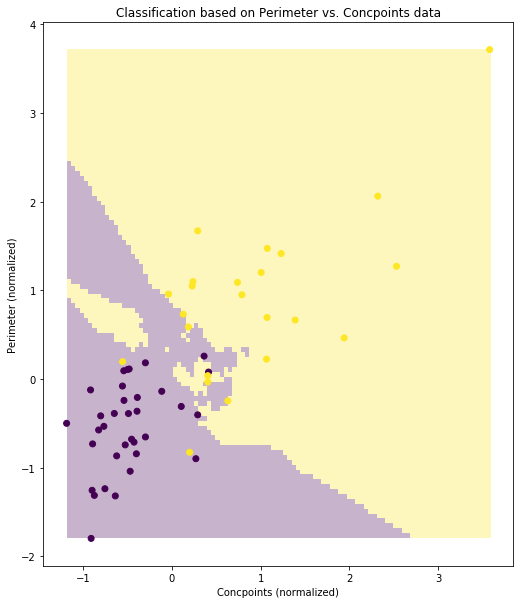

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


In [293]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
Y = y_train.reset_index()['cancer']
X = np.stack((X1, X2), axis=1)
m = KNeighborsClassifier(n_neighbors = 4).fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
Xv = np.stack((X1v, X2v), axis=1)
Yv = y_test.reset_index()['cancer']

dataShow(m, Xv, Yv, 0.0)
dataShow(m, Xv, Yv, 0.3)

### 2.1.2 Decision Boundary Plot

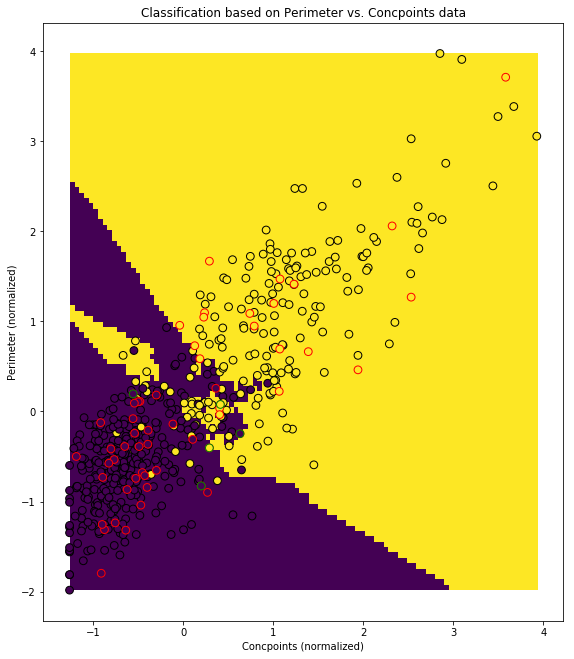

Legend (Circle Outlines):
   Black: Training
   Red: Testing
   Green: Misclassified data (true = color flipped)
   Purple: benign
   Yellow: malignant


In [294]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
Y = y_train.reset_index()['cancer']
X = np.stack((X1, X2), axis=1)
m = KNeighborsClassifier(n_neighbors = 4).fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
Xv = np.stack((X1v, X2v), axis=1)
Yv = y_test.reset_index()['cancer']

gridshow(m, X, Y, knn_Pred, Xv, Yv, 100)

### 2.1.3 Observations

kNN is picking up the underlying shape as seen in the graph in, but is overfitting. This overfitting behavior is visually seen since the decision boundary is not a smooth line, and is instead marred with cuts and holes as kNN tries to find groups where there may be none and tries to make sense of the noise as seen with the malignant nodes located among the benign ones.

## 2.2 Logistic Regression

## 2.2.1 Fit model

In [295]:
#Develop, train Logistic Regression model 
logRegModel = LogisticRegression()

#Next, fit the data by: logRegModel.fit(X, y) 
logRegModel.fit(X = X_train, y = y_train)

#Append column with predictions
logReg_Pred = logRegModel.predict(X_test)

#Print Accuracy
print("accuracy:", np.mean(logReg_Pred == y_test))

accuracy: 0.9298245614035088


D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 2.2.2 Predict Diagnosis on grid

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


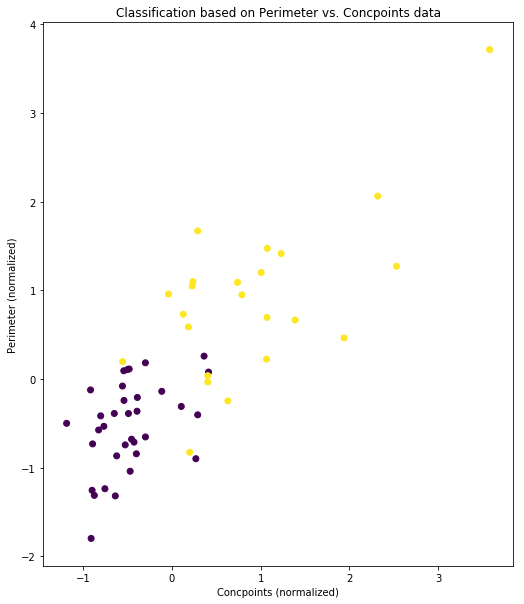

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


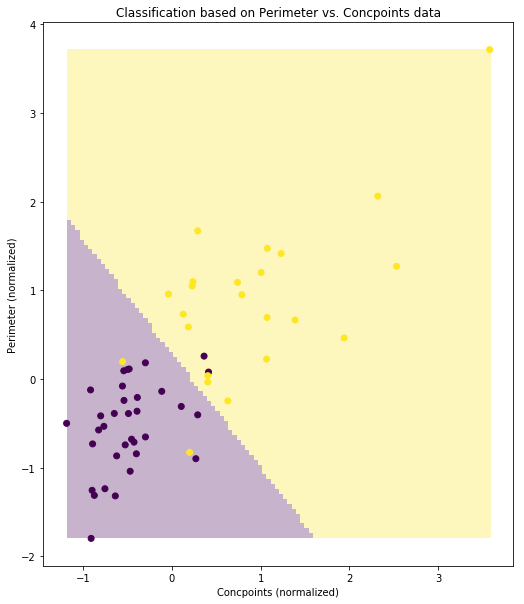

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


In [296]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
Y = y_train.reset_index()['cancer']
X = np.stack((X1, X2), axis=1)
m = LogisticRegression().fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
Xv = np.stack((X1v, X2v), axis=1)
Yv = y_test.reset_index()['cancer']

dataShow(m, Xv, Yv, 0.0)
dataShow(m, Xv, Yv, 0.3)

### 2.2.3 Decision Boundary Plot

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


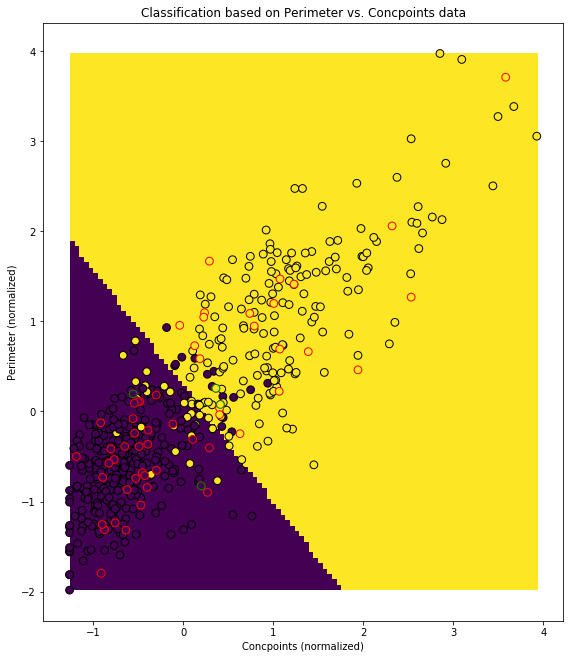

Legend (Circle Outlines):
   Black: Training
   Red: Testing
   Green: Misclassified data (true = color flipped)
   Purple: benign
   Yellow: malignant


In [297]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
Y = y_train.reset_index()['cancer']
X = np.stack((X1, X2), axis=1)
m = LogisticRegression().fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
Xv = np.stack((X1v, X2v), axis=1)
Yv = y_test.reset_index()['cancer']

gridshow(m, X, Y, logReg_Pred, Xv, Yv, 100)

### 2.2.4 Observations

Logistic Regression is picking up the underling structure as seen in the graph and is not overfitting it.

Logistic Regression has a higher accuracy than kNN- despite kNN seeming to overfit, this result is expected as the 5 values in the testing set are outside the unsmoothed bounds. Likewise, this holds true for the green dots in the regression model above as well. There seem to be an even match of malignant to benign cases on either side of the decision boundary for the regression model unlike kNN which seems to better classify its training data looking at the bounds visually; although the results for the testing are different. 

## 2.3 Feature Engineering

### 2.3.1 Create new feature

In [376]:
X_train['featureX'] = X_train['perimeter'] * X_train['concpoints']
X_test['featureX'] = X_test['perimeter'] * X_test['concpoints']

In [411]:
def dataShowFeature(m, X, Y, opacity):
    ex1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    ex2 = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    xx1, xx2 = np.meshgrid(ex1, ex2)
    xx3 = xx1 * xx2
    g = np.stack((xx1.ravel(), xx2.ravel(), xx3.ravel()), axis=1)
    hatY = m.predict(g).reshape(100,100)
    plt.figure(figsize=(10,10))

    #Print title, axis, legend
    plt.ylabel('Perimeter (normalized)')
    plt.xlabel('Concpoints (normalized)')
    plt.title('Classification based on Perimeter vs. Concpoints data')

    plt.imshow(hatY, extent=(X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()), interpolation='none', origin='lower', alpha = opacity)
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.show()    
    print("Legend (Circle Outlines):")
    print("   Purple: benign")
    print("   Yellow: malignant")

def gridshowFeature(m, X, Y, pred, Xv=None, Yv=None, nGrid=100):

    ex1 = np.linspace(X[:,0].min(), X[:,0].max(), nGrid)
    ex2 = np.linspace(X[:,1].min(), X[:,1].max(), nGrid)
    xx1, xx2 = np.meshgrid(ex1, ex2)
    xx3 = xx1 * xx2
    g = np.stack((xx1.ravel(), xx2.ravel(), xx3.ravel()), axis=1)
    hatY = m.predict(g).reshape(nGrid,nGrid)
    plt.figure(figsize=(10,10))
    plt.imshow(hatY, 
               extent=(X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()), 
               interpolation='none', origin='lower', alpha=1)
    Yvpred = m.predict(Xv)

    #####################
    #Finds predicted values that are different from actual
    df = pd.DataFrame({'x1':Xv[:,0],'x2':Xv[:,1],'yTrue':Yv, 'yPred':pred})
    df = df[df.yTrue != df.yPred]
    X1 = (df).reset_index()['x1']
    X2 = (df).reset_index()['x2']
    Ydf = (df).reset_index()['yPred']
    Xdf = np.stack((X1, X2), axis=1)
    #####################

    #Plots training data
    plt.scatter(X[:,0], X[:,1], c=Y, s=60, edgecolors='k')

    #Plots testing data
    plt.scatter(Xv[:,0], Xv[:,1], c=Yv, s=60, edgecolors='r')

    #Plots misclassified predictions
    plt.scatter(Xdf[:,0], Xdf[:,1], c=Ydf, s=60, edgecolors='g')

    #Print title, axis, legend
    plt.ylabel('Perimeter (normalized)')
    plt.xlabel('Concpoints (normalized)')
    plt.title('Classification based on Perimeter vs. Concpoints data')

    plt.show()
    print("Legend (Circle Outlines):")
    print("   Black: Training")
    print("   Red: Testing")
    print("   Green: Misclassified data (true = color flipped)")
    print("   Purple: benign")
    print("   Yellow: malignant")


### 2.3.2 Fit Logistic Regression Model

In [377]:
#Develop, train Logistic Regression model 
logRegModel = LogisticRegression()

#Next, fit the data by: logRegModel.fit(X, y) 
logRegModel.fit(X = X_train, y = y_train)

#Append column with predictions
logReg_Pred = logRegModel.predict(X_test)

#Print Accuracy
print("accuracy:", np.mean(logReg_Pred == y_test))

accuracy: 0.9298245614035088


D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 2.3.3 Create decision boundary plots

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


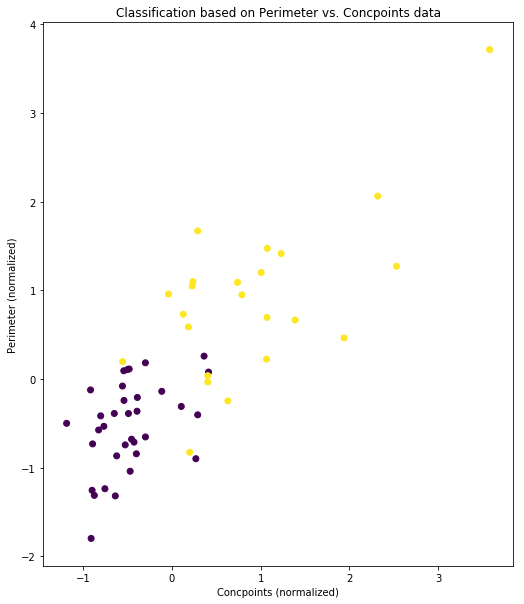

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


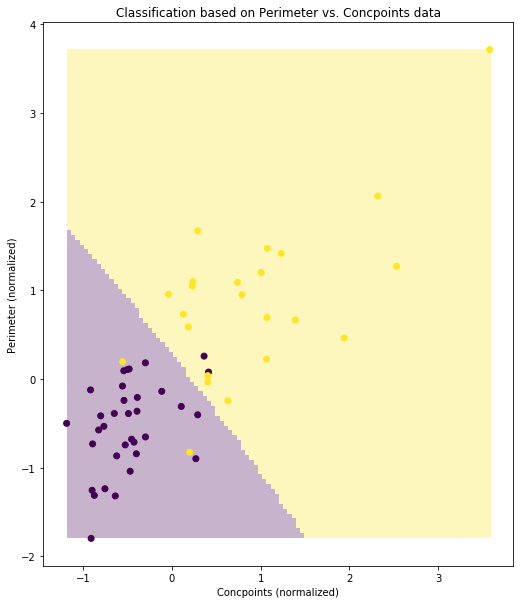

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


In [415]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
X3 = (X_train).reset_index()['featureX']
X = np.stack((X1, X2, X3), axis=1)

Y = y_train.reset_index()['cancer']
m = LogisticRegression().fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
X3v = (X_test).reset_index()['featureX']
Xv = np.stack((X1v, X2v, X3v), axis=1)

Yv = y_test.reset_index()['cancer']

dataShowFeature(m, Xv, Yv, 0.0)
dataShowFeature(m, Xv, Yv, 0.3)

### 2.3.2 Decision Boundary Plot

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


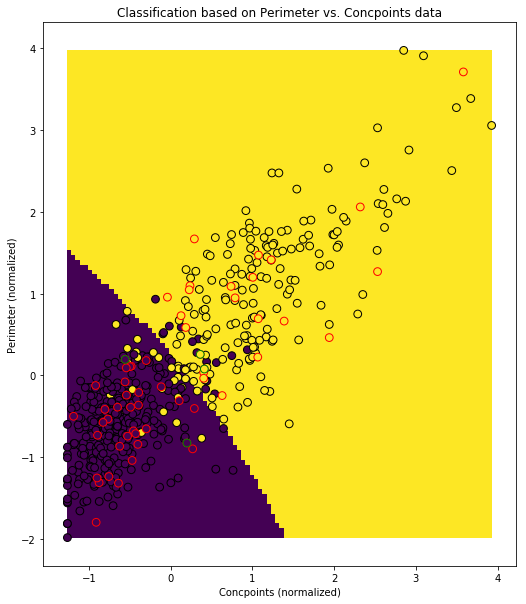

Legend (Circle Outlines):
   Black: Training
   Red: Testing
   Green: Misclassified data (true = color flipped)
   Purple: benign
   Yellow: malignant


In [410]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
X3 = (X_train).reset_index()['featureX']
X = np.stack((X1, X2, X3), axis=1)

Y = y_train.reset_index()['cancer']
m = LogisticRegression().fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
X3v = (X_test).reset_index()['featureX']
Xv = np.stack((X1v, X2v, X3v), axis=1)

Yv = y_test.reset_index()['cancer']

pred = m.predict(Xv)

gridshowFeature(m, X, Y, pred, Xv, Yv, 100)

### 2.2.4 Observations

Adding a feature has changed the shape of the decision boundary- it is no longer a straight line, but a curve. It classifies our testing set the same way as before though, and I do not believe it is overfitting, at least looking at it visually- there are an even number of malignant points aboveas benign points below the boundary.

### 2.3.5 Plot different boundaries

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


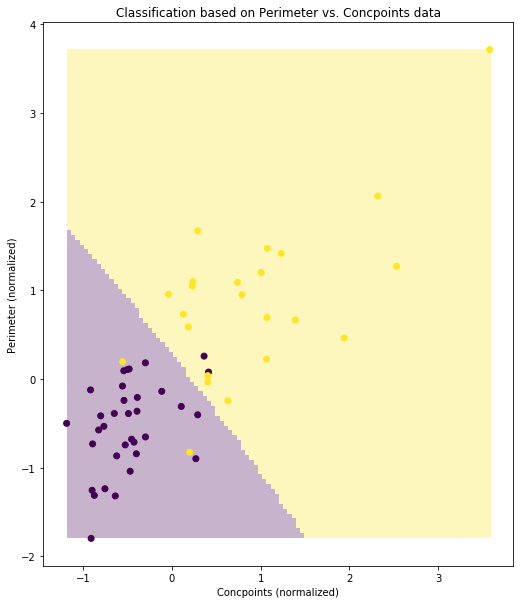

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


In [417]:
X_train['featureX'] = X_train['perimeter'] * X_train['perimeter']
X_test['featureX'] = X_test['perimeter'] * X_test['perimeter']

X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
X3 = (X_train).reset_index()['featureX']
X = np.stack((X1, X2, X3), axis=1)

Y = y_train.reset_index()['cancer']
m = LogisticRegression().fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
X3v = (X_test).reset_index()['featureX']
Xv = np.stack((X1v, X2v, X3v), axis=1)

Yv = y_test.reset_index()['cancer']

dataShowFeature(m, Xv, Yv, 0.3)


The deicison boundary is a bit more of a straight line- once again, it does not appear to overfit our data as the line is a clean division between the data.

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


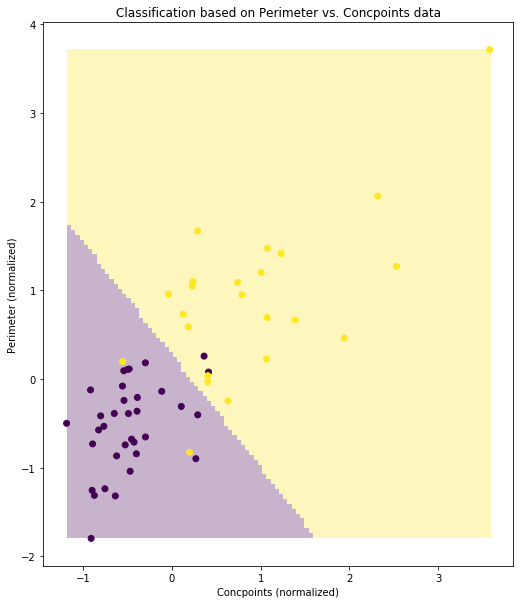

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


In [420]:
X_train['featureX'] = X_train['perimeter'] * X_train['perimeter'] * 1000 
X_test['featureX'] = X_test['perimeter'] * X_test['perimeter'] * 1000

X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
X3 = (X_train).reset_index()['featureX']
X = np.stack((X1, X2, X3), axis=1)

Y = y_train.reset_index()['cancer']
m = LogisticRegression().fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
X3v = (X_test).reset_index()['featureX']
Xv = np.stack((X1v, X2v, X3v), axis=1)

Yv = y_test.reset_index()['cancer']

dataShowFeature(m, Xv, Yv, 0.3)


Adding a multiplicative scale to our third feature does not change the deicison boundary apparently.

## 2.4. Support Vector Machines

In [356]:
#Develop, train kNN model 
svm = SVC()

#Next, fit the data by: kNNTool.fit(X, y) 
svm.fit(X = X_train, y = y_train)

#Append column with predictions
svm_Pred = svm.predict(X_test)

#Print Accuracy
print("accuracy:", np.mean(y_test == svm_Pred))

accuracy: 0.9298245614035088


D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### 2.4.1 Predict Diagnosis on grid

D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


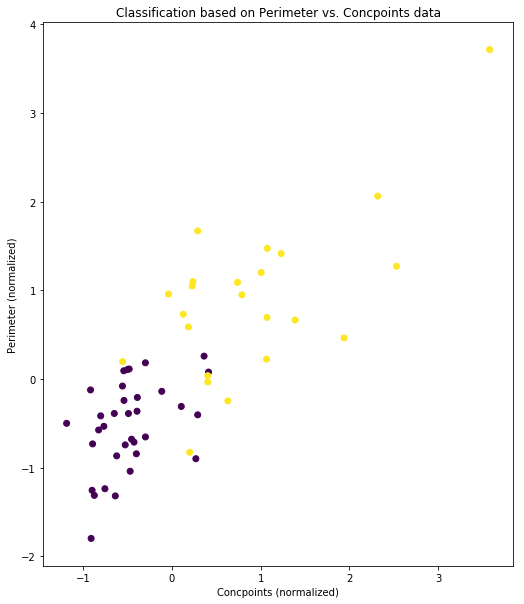

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant
Linear Kernel


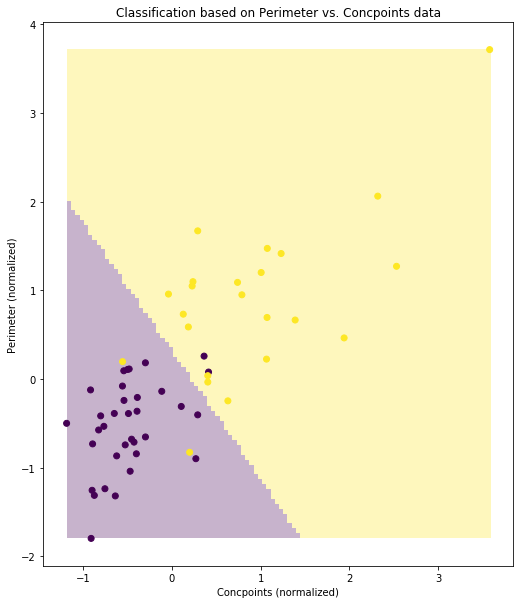

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant
RBF Kernel


D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


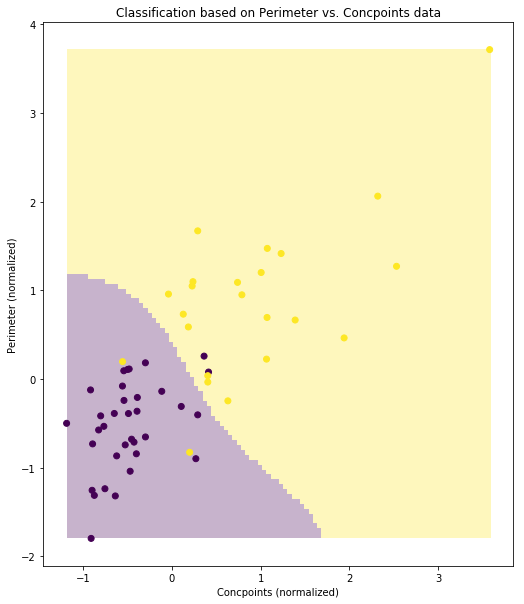

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant
Poly Kernel


D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


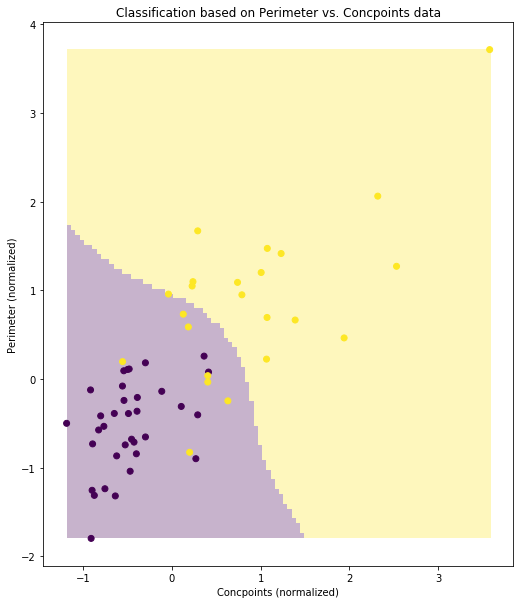

Legend (Circle Outlines):
   Purple: benign
   Yellow: malignant


In [361]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
Y = y_train.reset_index()['cancer']
X = np.stack((X1, X2), axis=1)
m = svm.fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
Xv = np.stack((X1v, X2v), axis=1)
Yv = y_test.reset_index()['cancer']

dataShow(m, Xv, Yv, 0.0)

print("Linear Kernel")
dataShow(SVC(kernel = 'linear').fit(X,Y), Xv, Yv, 0.3)

print("RBF Kernel")
dataShow(SVC(kernel = 'rbf').fit(X,Y), Xv, Yv, 0.3)

print("Poly Kernel")
dataShow(SVC(kernel = 'poly').fit(X,Y), Xv, Yv, 0.3)


### 2.4.2 Decision Boundary Plot

Linear Kernel


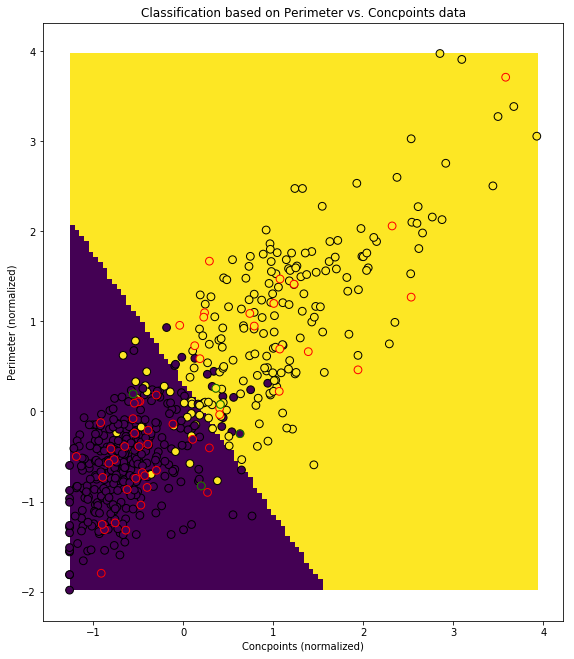

Legend (Circle Outlines):
   Black: Training
   Red: Testing
   Green: Misclassified data (true = color flipped)
   Purple: benign
   Yellow: malignant
RBF Kernel


D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


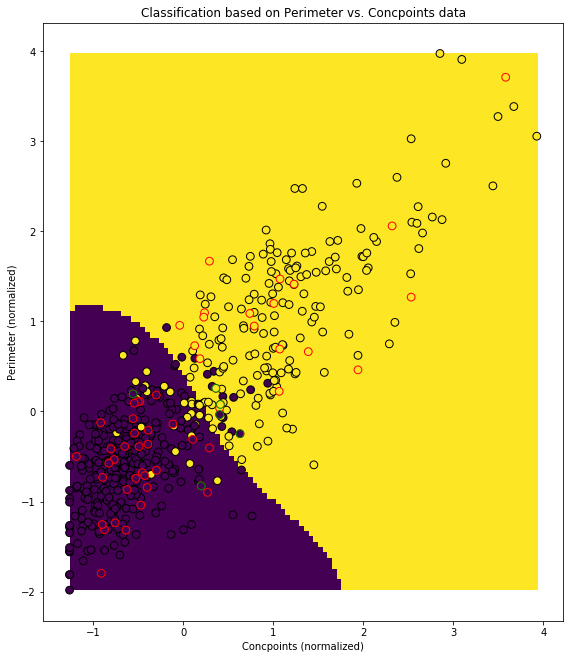

Legend (Circle Outlines):
   Black: Training
   Red: Testing
   Green: Misclassified data (true = color flipped)
   Purple: benign
   Yellow: malignant
Poly Kernel


D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


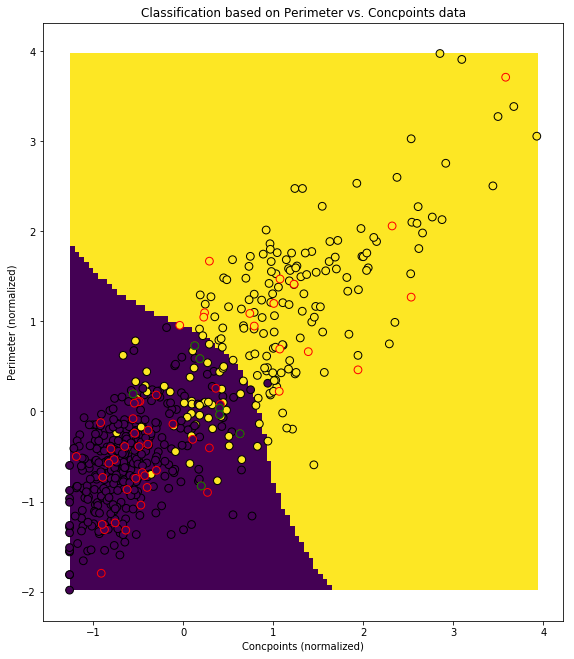

Legend (Circle Outlines):
   Black: Training
   Red: Testing
   Green: Misclassified data (true = color flipped)
   Purple: benign
   Yellow: malignant


In [363]:
## plotting function
#xV = testing
    
X1 = (X_train).reset_index()['concpoints']
X2 = (X_train).reset_index()['perimeter']
Y = y_train.reset_index()['cancer']
X = np.stack((X1, X2), axis=1)
m = KNeighborsClassifier(n_neighbors = 4).fit(X,Y)

X1v = (X_test).reset_index()['concpoints']
X2v = (X_test).reset_index()['perimeter']
Xv = np.stack((X1v, X2v), axis=1)
Yv = y_test.reset_index()['cancer']

print("Linear Kernel")
svmL_pred = SVC(kernel = 'linear').fit(X,Y).predict(X_test)
gridshow(SVC(kernel = 'linear').fit(X,Y), X, Y, svmL_pred, Xv, Yv, 100)

print("RBF Kernel")
svmR_pred = SVC(kernel = 'rbf').fit(X,Y).predict(X_test)
gridshow(SVC(kernel = 'rbf').fit(X,Y), X, Y, svmR_pred, Xv, Yv, 100)

print("Poly Kernel")
svmP_pred = SVC(kernel = 'poly').fit(X,Y).predict(X_test)
gridshow(SVC(kernel = 'poly').fit(X,Y), X, Y, svmP_pred, Xv, Yv, 100)

### 2.4.5 Observations
The Poly kernel although intuitlvely should have given us the best results, it misfitted our data and misclassified the most number of points (as seen by the largest number of green dots in 2.4.2. RBF laid somewhere in the middle- it fit the data just as well as the linear model, but curved itself and seemed to better fit our data; although there was no improvement in accuracy on our testing data.

Compared to KNN, RBF didn't appear to try and force itself into our data, as can probably be inferred by only having a line as opposed to pockets. Compared to logistic regression- SVM is a lot more curvy for RBF and Poly, and I'd be hard pressed to tell the difference between its linear kernel and logistic regression.

## 3. ROC Curve

In [370]:
#https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
def confusion_matrix(actual, pred):
    K = len(np.unique(actual)) # Number of classes 
    result = np.zeros((K, K), dtype='int')
    for i in range(len(actual)):
        result[actual[i]][pred[i]] += 1
    return(result)

#https://stackoverflow.com/questions/48100173/how-to-get-precision-recall-and-f-measure-from-confusion-matrix-in-python
def precision(matrix): 
    tp = matrix[1][1] 
    fp = matrix[0][1] 
    return(np.round(tp/(tp+fp), 5))

def recall(matrix):
    tp = matrix[1][1] 
    fn = matrix[1][0] 
    return(np.round(tp/(tp+fn), 5))

def tpr_(matrix):
    tp = matrix[1][1] 
    fn = matrix[1][0] 
    return(np.round(tp/(tp+fn), 5))

def fpr_(matrix):
    fp = matrix[0][1] 
    tn = matrix[0][0] 
    return(np.round(fp/(fp+tn), 5))

def accuracy(actual, pred):
    return(np.round(  (pred == actual).sum()/len(actual)  , 5))

def fscore(precision, recall):
    return(np.round(2 * (precision * recall) / (precision + recall), 5))

def thresholdPredData(threshold, pred):
    predMal = pred
    for i in range(len(predMal)):
        if((threshold == 1.0) & (predMal[i].astype(float) == 1.0)):
            predMal[i] = 0.0
        elif((threshold == 0.0) & (predMal[i].astype(float) == 0.0)):
            predMal[i] = 1.0
        elif(predMal[i] > threshold):
            predMal[i] = 1
        else:
            predMal[i] = 0
    return(predMal.astype(int))

## 3.1 Split data into 75-25 training-validation split

In [366]:
Train_v, Test_v = train_test_split(Train, train_size = 0.75, random_state = 1)
xv_train = Train_v[['perimeter', 'concpoints']]
yv_train = Train_v.cancer.values
xv_test = Test_v[['perimeter', 'concpoints']]
yv_test = Test_v.cancer.values



In [429]:
TrainFeature_v = pd.DataFrame({'perimeter':Train_v.perimeter.values, 
              'concpoints': Train_v.perimeter.values, 
              'featureX':Train_v.perimeter.values * Train_v.concpoints.values,
              'cancer':Train_v.cancer.values})

TrainFeature_v = pd.DataFrame({'perimeter':Test_v.perimeter.values, 
              'concpoints': Test_v.perimeter.values, 
              'featureX':Test_v.perimeter.values * Train_v.concpoints.values,
              'cancer':Test_v.cancer.values})



## 3.2 Select good models

In [367]:
#Print Accuracy
print("kNN parameters comparison:")
for i in range(1,10):
    knnModel = KNeighborsClassifier(n_neighbors = i).fit(X = xv_train, y = yv_train)
    prediction = knnModel.predict(xv_test)
    print("    k:", i, "Acc:", np.round(  (prediction == yv_test).sum()/len(prediction)  , 2))
    
#Print Accuracy
print("")
print("Logistic Regression solver comparison:")
for i in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        logReg = LogisticRegression(solver = i).fit(X = xv_train, y = yv_train)
        prediction = logReg.predict(xv_test)
        print("    solver:", i, "Acc:", np.round(  (prediction == yv_test).sum()/len(prediction)  , 2))
        
#Print Accuracy
print("")
print("SVM kernel comparison:")
for i in ['linear', 'rbf', 'poly']:
    svc = SVC(kernel = i, probability=True).fit(X = xv_train, y = yv_train)
    prediction = svc.predict(xv_test)
    print("    kernel:", i, "Acc:", np.round(  (prediction == yv_test).sum()/len(prediction)  , 2))

kNN parameters comparison:
    k: 1 Acc: 0.91
    k: 2 Acc: 0.9
    k: 3 Acc: 0.95
    k: 4 Acc: 0.91
    k: 5 Acc: 0.94
    k: 6 Acc: 0.91
    k: 7 Acc: 0.91
    k: 8 Acc: 0.9
    k: 9 Acc: 0.91

Logistic Regression solver comparison:
    solver: newton-cg Acc: 0.91
    solver: lbfgs Acc: 0.91
    solver: liblinear Acc: 0.91
    solver: sag Acc: 0.91
    solver: saga Acc: 0.91

SVM kernel comparison:
    kernel: linear Acc: 0.91
    kernel: rbf Acc: 0.91
    kernel: poly Acc: 0.89


D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 3.3 Create confusion matrix, accuracy, precision, recall, and f-score

In [368]:
#kNN model
knnModelVal = KNeighborsClassifier(n_neighbors = 3).fit(X = xv_train, y = yv_train)
pred_kNN = knnModelVal.predict(xv_test)

#LogisticRegression model
logRegVal = LogisticRegression(solver = 'newton-cg').fit(X = xv_train, y = yv_train)
pred_logReg = logRegVal.predict(xv_test)

#SVM model
svc = SVC(kernel = 'linear', probability=True).fit(X = xv_train, y = yv_train)
pred_svc = svc.predict(xv_test)

In [371]:
models = ['kNN', 'Logistic Regression', 'SVM']
predictions = [pred_kNN, pred_logReg, pred_svc]

for i in range(3):
    print("Model Name: ", models[i])
    
    c_matrix = confusion_matrix(yv_test, predictions[i])
    print("Confusion Matrix: \n", c_matrix)
    
    prec = precision(c_matrix)
    print("Precision: ", prec)
    
    rec = recall(c_matrix)
    print("Recall: ", rec)
    
    acc = accuracy(yv_test, predictions[i])
    print("Accuracy: ", acc)
    
    fscr = fscore(prec, rec)
    print("f-score:", fscr)
    
    print("")

Model Name:  kNN
Confusion Matrix: 
 [[78  2]
 [ 5 43]]
Precision:  0.95556
Recall:  0.89583
Accuracy:  0.94531
f-score: 0.92473

Model Name:  Logistic Regression
Confusion Matrix: 
 [[77  3]
 [ 8 40]]
Precision:  0.93023
Recall:  0.83333
Accuracy:  0.91406
f-score: 0.87912

Model Name:  SVM
Confusion Matrix: 
 [[77  3]
 [ 8 40]]
Precision:  0.93023
Recall:  0.83333
Accuracy:  0.91406
f-score: 0.87912



## 3.4, 3.5, 3.6 Calculate classification on threshold

In [372]:
models = [knnModelVal, logRegVal, svc]
model_name = ['kNN', 'Logistic Regression', 'SVM']

fpr = []
tpr = []
model_arr = []
thresholds_arr = []
actual = yv_test

for i in range(len(models)):
    model = models[i]
    group_name = model_name[i]

    thresholds = np.round(np.linspace(0, 1, 1001),6)
    for i in thresholds:
        predMal = model.predict_proba(xv_test)[:, 1]
        pred = thresholdPredData(i, predMal)
        c_matrix = confusion_matrix(actual, pred)
        tpr.append(tpr_(c_matrix))
        fpr.append(fpr_(c_matrix))    
        model_arr.append(group_name)
        thresholds_arr.append(i)
    
df = pd.DataFrame({'threshold':thresholds_arr, 'fpr':fpr, 'tpr':tpr, 'model_name':model_arr})

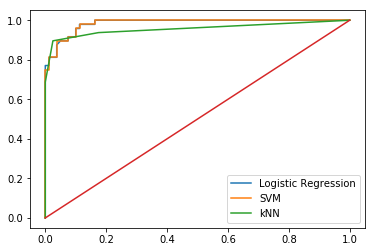

In [373]:
dfa = df.groupby('model_name')

x = np.linspace(0, 1)

fig, ax = plt.subplots()
for name, group in dfa:
    ax.plot(group.fpr, group.tpr, label=name),
ax.legend()
plt.plot(x, x + 0, linestyle='solid')
plt.show()

Logistic Regression and SVM would intuitively give the same results as they're fitting a linear line through the data to make the decision boundary. Curiously, this approach performs better than kNN as seen by the overall higher ROC curve. Among kNN and Logistic Regression, Regression appears to perform slightly better as seen by the slightly higher blue curve in places.